In [45]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from os import getcwd
import os
import seaborn as sns
from collections import Counter

In [2]:
cwd = getcwd()
os.chdir("..")
data = pd.read_csv(getcwd() + "/data/GFM_Data_VADER_Sentiment.csv")

## Data Preprocessing

Convert keyword list back to Python List

In [3]:
data.columns

Index(['URL', 'All_Keywords', 'Title', 'Reason_For_Fund', 'Total_Raised',
       'Total_Goal', 'Percent_Reached', 'Campaign_Date', 'Organizer',
       'Beneficiary', 'Location', 'Donors', 'Shares', 'Followers',
       'Num_Updates', 'Num_Comments', 'Is_Charity', 'Charity', 'Currency_Code',
       'Donation_Count', 'Comments_Enabled', 'Donations_Enabled', 'Country',
       'Is_Business', 'Is_Team', 'Campaign_Photo_URL', 'Description', 'State',
       'City', 'Compound_Description', 'Neg_Description', 'Neu_Description',
       'Pos_Description', 'Compound_Title', 'Neg_Title', 'Neu_Title',
       'Pos_Title', 'Description_Length', 'Title_Length'],
      dtype='object')

In [4]:
def reformat_keyword_list(keywords):
    """
    Converts string version of keywords list back to a python list

    Args:
        keywords (string): Keyword list as one string

    Returns:
        [list]: Python list of each keyword separated into strings
    """    
    kw = keywords.replace('[', '').replace(']', '').replace('\'', '').replace(' ', '')
    kw = kw.split(",")
    return np.array(list(set(kw)))

In [5]:
data.All_Keywords = data.All_Keywords.apply(reformat_keyword_list)

Standardize Data and Plot Correlation Matrix

<AxesSubplot:>

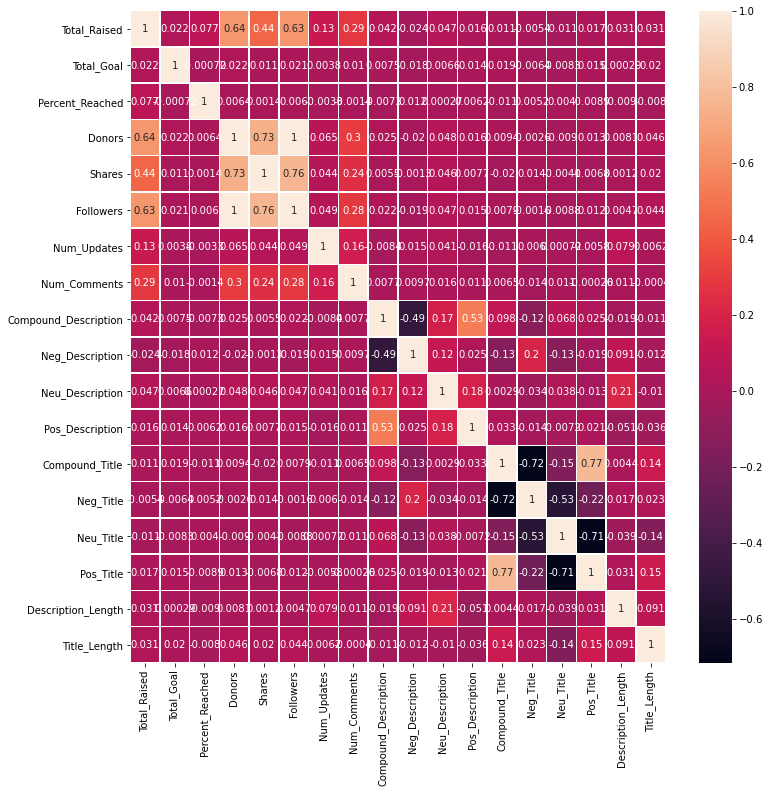

In [6]:
data_num = data[['Total_Raised', 'Total_Goal', 'Percent_Reached','Donors', 'Shares', 'Followers',
       'Num_Updates', 'Num_Comments',
                 'Compound_Description', 'Neg_Description', 'Neu_Description',
            'Pos_Description', 'Compound_Title', 'Neg_Title', 'Neu_Title', 'Pos_Title', 
             'Description_Length', 'Title_Length']].fillna(0)

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_num), columns=data_num.columns)

corr = data_scaled.corr()
fig, ax = plt.subplots(figsize=(12,12))       
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

PCA

Text(0.5, 1.0, 'Explained Variance By Principal Components')

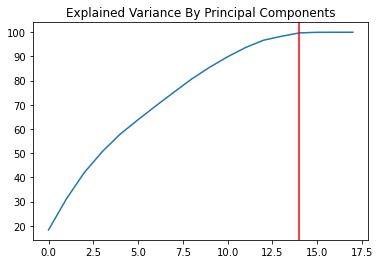

In [56]:
pca = PCA(18).fit(data_scaled)
variance_ratios = pca.explained_variance_ratio_.cumsum()
plt.plot([i for i in range(0, 18)], variance_ratios*100)
plt.axvline(14, c='red')
plt.title("Explained Variance By Principal Components")

In [57]:
pca_data = PCA(14).fit_transform(data_scaled)

14 components seems to capture 100% of the data, this makes sense as donors, shares, and followers were all highly correlated.

## KMeans

In [58]:
inertias = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pca_data)
    inertias.append(kmeans.inertia_)

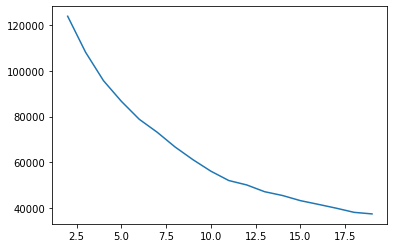

In [59]:
plt.plot([i for i in range(2, 20)], inertias)

Now we will run KMeans with 11 clusters on the PCA data. After running, we will use the labels to assign each campaign to one of the clusters.

In [60]:
kmeans = KMeans(n_clusters=11).fit(pca_data)

In [61]:
data['KMeans_Clusters'] = kmeans.labels_
data.head(2)

,URL,All_Keywords,Title,Reason_For_Fund,Total_Raised,Total_Goal,Percent_Reached,Campaign_Date,Organizer,Beneficiary,...,Pos_Description,Compound_Title,Neg_Title,Neu_Title,Pos_Title,Description_Length,Title_Length,KMeans_Clusters,GMM_Clusters,DBSCAN_Clusters
0,https://www.gofundme.com/f/let-them-stay-home,[opiate],Let them stay home,Accidents & Emergencies,4223.0,4000.0,1.06,2017-07-12 00:00:00,Eddie Crandall,NaN,...,0.092,0.0,0.0,1.0,0.0,616,4,6,0,0
1,https://www.gofundme.com/f/mark-richards-medic...,[opiate],Mark Richards Medical Fund,"Medical, Illness & Healing",2545.0,1500.0,1.70,2017-02-15 00:00:00,Cat Spin,Mark Richards,...,0.109,0.0,0.0,1.0,0.0,69,4,6,0,0


Next, we will group all the campaigns into their clusters and run descriptive stats

In [62]:
km_groups = data.groupby(by='KMeans_Clusters')

In [63]:
km_groups.count()

,URL,All_Keywords,Title,Reason_For_Fund,Total_Raised,Total_Goal,Percent_Reached,Campaign_Date,Organizer,Beneficiary,...,Neu_Description,Pos_Description,Compound_Title,Neg_Title,Neu_Title,Pos_Title,Description_Length,Title_Length,GMM_Clusters,DBSCAN_Clusters
KMeans_Clusters,,,,,,,,,,,,,,,,,,,,,
0,1084,1084,1084,1084,979,929,929,1084,1084,422,...,1084,1084,1084,1084,1084,1084,1084,1084,1084,1084
1,1279,1279,1279,1279,1197,1121,1121,1279,1279,538,...,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279
2,7,7,7,7,6,6,6,7,7,6,...,7,7,7,7,7,7,7,7,7,7
3,1388,1388,1388,1388,1262,1183,1183,1388,1388,579,...,1388,1388,1388,1388,1388,1388,1388,1388,1388,1388
4,306,306,306,306,299,0,0,306,306,60,...,306,306,306,306,306,306,306,306,306,306
5,5,5,5,5,5,4,4,5,5,4,...,5,5,5,5,5,5,5,5,5,5
6,2879,2879,2879,2879,2685,2495,2495,2879,2879,1158,...,2879,2879,2879,2879,2879,2879,2879,2879,2879,2879
7,913,913,913,913,799,758,758,913,913,314,...,913,913,913,913,913,913,913,913,913,913
8,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1


In [64]:
# chose median because of outliers that skewed mean
km_groups.median()

,Total_Raised,Total_Goal,Percent_Reached,Donors,Shares,Followers,Num_Updates,Num_Comments,Is_Charity,Donation_Count,...,Neu_Description,Pos_Description,Compound_Title,Neg_Title,Neu_Title,Pos_Title,Description_Length,Title_Length,GMM_Clusters,DBSCAN_Clusters
KMeans_Clusters,,,,,,,,,,,,,,,,,,,,,
0,5565.0,13000.0,0.560,69.0,362.0,69.0,0.0,0.0,False,61.0,...,0.788,0.147,0.4019,0.000,0.645,0.351,405.5,7.0,6.0,2.0
1,5395.0,10000.0,0.600,68.0,464.0,70.0,0.0,0.0,False,67.0,...,0.761,0.148,-0.3818,0.458,0.455,0.000,312.0,5.0,0.0,-1.0
2,876401.0,550000.0,1.405,24000.0,109100.0,26500.0,0.0,0.0,False,24230.0,...,0.821,0.134,0.0000,0.000,0.615,0.209,197.0,6.0,3.0,-1.0
3,5122.0,10000.0,0.610,64.5,369.0,64.0,0.0,0.0,False,63.0,...,0.776,0.156,0.4574,0.000,0.469,0.521,323.5,4.0,6.0,2.0
4,1050.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,False,15.0,...,0.000,0.000,0.0000,0.000,0.702,0.000,0.0,5.0,4.0,3.0
5,595210.0,750000.0,0.835,9800.0,39750.0,9850.0,5.0,4069.0,False,11314.0,...,0.777,0.184,0.0000,0.000,1.000,0.000,405.0,4.0,3.0,-1.0
6,4421.0,10000.0,0.610,55.0,370.0,56.0,0.0,0.0,False,55.0,...,0.783,0.151,0.0000,0.000,1.000,0.000,327.0,4.0,6.0,0.0
7,3930.0,10000.0,0.480,52.0,313.5,52.0,0.0,0.0,False,47.0,...,0.777,0.091,0.0000,0.000,0.722,0.000,354.0,5.0,6.0,-1.0
8,155558.0,1.0,155558.000,775.0,2200.0,793.0,0.0,0.0,False,945.0,...,0.724,0.204,0.0000,0.000,1.000,0.000,347.0,3.0,4.0,-1.0


In [65]:
km_groups.get_group(0).head(2)

,URL,All_Keywords,Title,Reason_For_Fund,Total_Raised,Total_Goal,Percent_Reached,Campaign_Date,Organizer,Beneficiary,...,Pos_Description,Compound_Title,Neg_Title,Neu_Title,Pos_Title,Description_Length,Title_Length,KMeans_Clusters,GMM_Clusters,DBSCAN_Clusters
9,https://www.gofundme.com/f/taylor039s-road-to-...,"[addict, opiate, addiction]",Taylor's Road to Recovery - The Price of Addic...,"Medical, Illness & Healing",37330.0,40000.0,0.93,2020-11-04 00:00:00,Carolyn Clark,NaN,...,0.143,0.0000,0.0,1.000,0.000,624,9,0,0,-1
11,https://www.gofundme.com/f/addicted-to-life-no...,"[opiate, addiction]",Rise Up! Sober Fitness and Recovery Project,Community & Neighbors,11015.0,20000.0,0.55,2020-12-02 00:00:00,Rob DiTursi,NaN,...,0.197,0.3382,0.0,0.715,0.285,492,7,0,0,2


In [66]:
def get_top_keywords(groups, cluster):
    """
    Given a pandas group and the cluster number, returns an alphabetically sorted dictionary 
    of each keyword and the number of times it appears
    """
    kw = np.array(groups.get_group(cluster).All_Keywords).flatten()
    kw.tolist()
    keywords = [i[0] for i in kw]
    occurences = dict(Counter(keywords)) 
    sorted_occ = {}
    sorted_keys = sorted(occurences) 

    for w in sorted_keys:
        sorted_occ[w] = occurences[w]

    return sorted_occ

In [67]:
get_top_keywords(km_groups, 0)

{'addict': 126,
 'addiction': 85,
 'demon': 87,
 'dependency': 106,
 'drugs': 74,
 'heroin': 54,
 'opiate': 98,
 'opioid': 87,
 'overdose': 37,
 'recovery': 165,
 'rehab': 89,
 'rehabilitation': 76}

In [68]:
get_top_keywords(km_groups, 1)

{'addict': 111,
 'addiction': 120,
 'demon': 190,
 'dependency': 46,
 'drugs': 138,
 'heroin': 96,
 'opiate': 67,
 'opioid': 86,
 'overdose': 98,
 'recovery': 174,
 'rehab': 90,
 'rehabilitation': 63}

To visualize results, we will plot the number of appearances of each keyword in every cluster, as well as the median amount raised and the median goal reached

In [124]:
def plot_kw_for_group(groups, group_num):
    g = get_top_keywords(groups, group_num)
    fig = plt.figure(figsize=(13, 6))
    ax = fig.subplots()
    ax.bar(g.keys(), g.values())
    ax.set_title(f"Most Common Keywords for Cluster {group_num}")
    
    # plot success features
    median_percent_raised = groups.get_group(group_num).median().Percent_Reached
    goal = AnchoredText(f"Median Percent Reached: {median_percent_raised}", loc='upper right')
    amount_raised = groups.get_group(group_num).median().Total_Raised
    raised = AnchoredText(f"Median Total Raised: ${amount_raised}", loc='upper left')
    
    ax.add_artist(goal)
    ax.add_artist(raised)
    #fig.savefig(path)

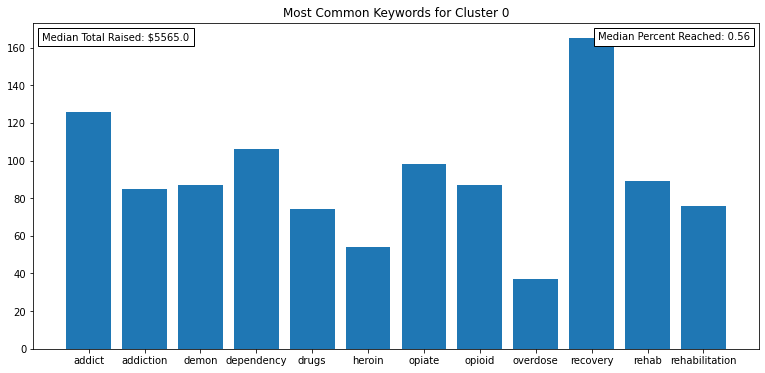

In [70]:
plot_kw_for_group(km_groups, 0)

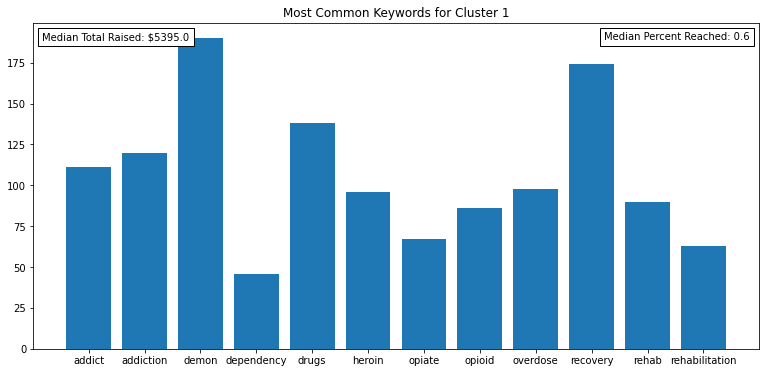

In [71]:
plot_kw_for_group(km_groups, 1)

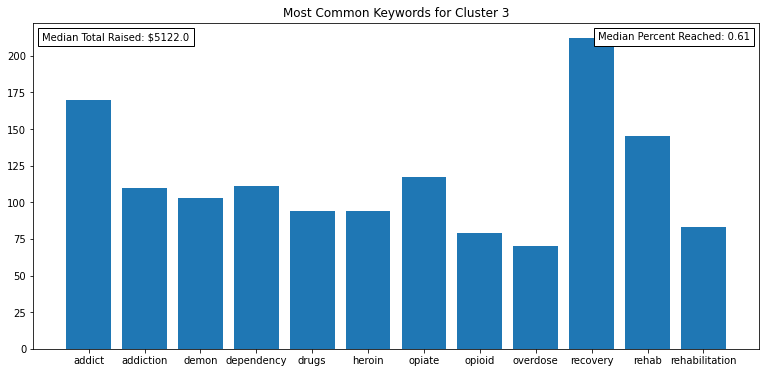

In [125]:
plot_kw_for_group(km_groups, 3)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


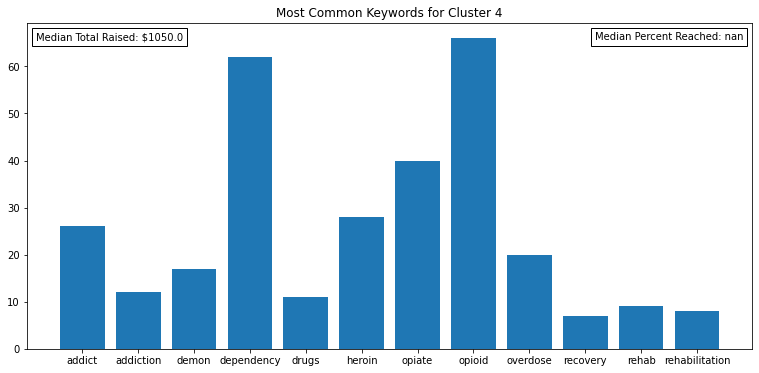

In [74]:
plot_kw_for_group(km_groups, 4)

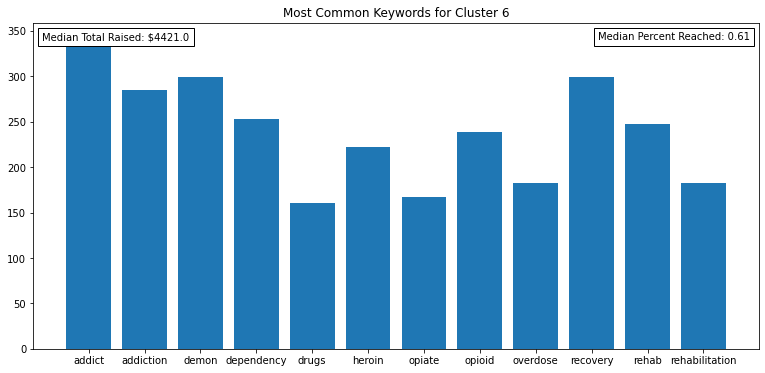

In [76]:
plot_kw_for_group(km_groups, 6)

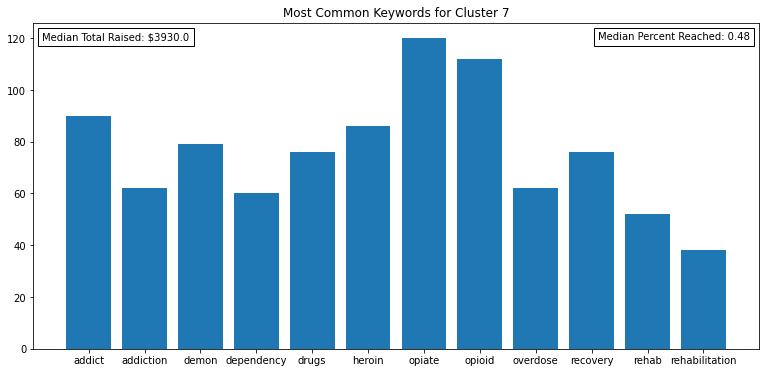

In [77]:
plot_kw_for_group(km_groups, 7)

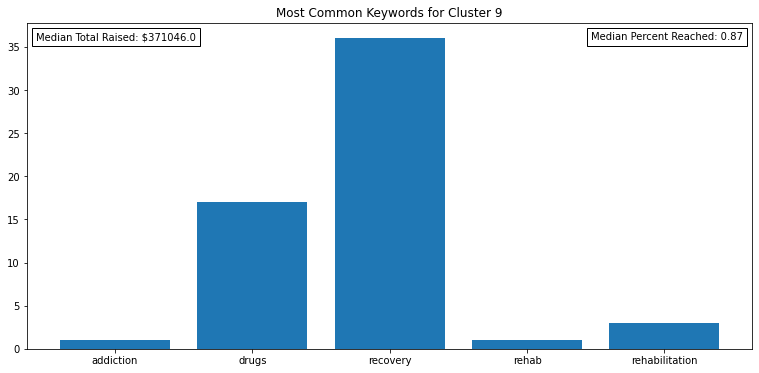

In [79]:
plot_kw_for_group(km_groups, 9)

Overall, there is not too much information to discern from here. Recovery and rehabilitation tended to be more common for campaigns that reached more of their goal but it is possible that KMeans did not perform very accurate clustering, so I will try GMM instead.

# GMM

To choose optimal component number, will use the elbow method for BIC and AIC curves

In [83]:
bic_vals = []
aic_vals = []
for i in range(1, 50):
    gmm = GaussianMixture(i, reg_covar=1e-5).fit(pca_data)
    bic_vals.append(gmm.bic(pca_data))
    aic_vals.append(gmm.aic(pca_data))

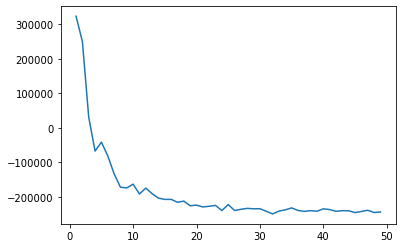

In [84]:
plt.plot([i for i in range(1, 50)], bic_vals)

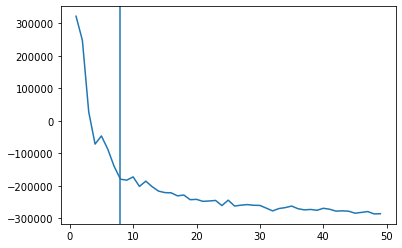

In [101]:
plt.plot([i for i in range(1, 50)], aic_vals)
plt.axvline(8)

13 appears to be the optimal number of clusters

In [102]:
gmm = GaussianMixture(8, random_state=1234).fit(data_num)
clusters = gmm.predict(data_num)

In [103]:
data['GMM_Clusters'] = clusters

In [104]:
data.head(2)

,URL,All_Keywords,Title,Reason_For_Fund,Total_Raised,Total_Goal,Percent_Reached,Campaign_Date,Organizer,Beneficiary,...,Pos_Description,Compound_Title,Neg_Title,Neu_Title,Pos_Title,Description_Length,Title_Length,KMeans_Clusters,GMM_Clusters,DBSCAN_Clusters
0,https://www.gofundme.com/f/let-them-stay-home,[opiate],Let them stay home,Accidents & Emergencies,4223.0,4000.0,1.06,2017-07-12 00:00:00,Eddie Crandall,NaN,...,0.092,0.0,0.0,1.0,0.0,616,4,6,7,0
1,https://www.gofundme.com/f/mark-richards-medic...,[opiate],Mark Richards Medical Fund,"Medical, Illness & Healing",2545.0,1500.0,1.70,2017-02-15 00:00:00,Cat Spin,Mark Richards,...,0.109,0.0,0.0,1.0,0.0,69,4,6,7,0


In [105]:
gmm_groups = data.groupby(by='GMM_Clusters')
gmm_groups.count()

,URL,All_Keywords,Title,Reason_For_Fund,Total_Raised,Total_Goal,Percent_Reached,Campaign_Date,Organizer,Beneficiary,...,Neu_Description,Pos_Description,Compound_Title,Neg_Title,Neu_Title,Pos_Title,Description_Length,Title_Length,KMeans_Clusters,DBSCAN_Clusters
GMM_Clusters,,,,,,,,,,,,,,,,,,,,,
0,5001,5001,5001,5001,4500,4215,4215,5001,5001,1862,...,5001,5001,5001,5001,5001,5001,5001,5001,5001,5001
1,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
2,907,907,907,907,869,799,799,907,907,493,...,907,907,907,907,907,907,907,907,907,907
3,307,307,307,307,300,1,1,307,307,60,...,307,307,307,307,307,307,307,307,307,307
4,2,2,2,2,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,2
5,645,645,645,645,618,597,597,645,645,346,...,645,645,645,645,645,645,645,645,645,645
6,217,217,217,217,211,196,196,217,217,108,...,217,217,217,217,217,217,217,217,217,217
7,841,841,841,841,789,738,738,841,841,247,...,841,841,841,841,841,841,841,841,841,841


In [106]:
gmm_groups.median()

,Total_Raised,Total_Goal,Percent_Reached,Donors,Shares,Followers,Num_Updates,Num_Comments,Is_Charity,Donation_Count,...,Neu_Description,Pos_Description,Compound_Title,Neg_Title,Neu_Title,Pos_Title,Description_Length,Title_Length,KMeans_Clusters,DBSCAN_Clusters
GMM_Clusters,,,,,,,,,,,,,,,,,,,,,
0,3945.0,10000.0,0.560,52.0,345.0,53.0,0.0,0.0,0.0,50.0,...,0.777,0.146,0.00000,0.0000,0.6580,0.000,317.0,5.0,3.0,0.0
1,110.0,200000000.0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,2.0,...,0.770,0.224,0.65970,0.0000,0.5260,0.474,241.0,8.0,10.0,-1.0
2,18231.0,50000.0,0.690,187.0,863.0,192.0,0.0,0.0,0.0,204.0,...,0.782,0.162,0.00000,0.0000,1.0000,0.000,380.0,5.0,6.0,0.0
3,1052.5,1.0,155558.000,775.0,2200.0,793.0,0.0,0.0,0.0,15.0,...,0.000,0.000,0.00000,0.0000,0.7060,0.000,0.0,5.0,4.0,3.0
4,1102.5,9500000.0,0.000,34.0,32.0,34.0,2.5,0.0,0.0,19.0,...,0.777,0.107,-0.33525,0.2645,0.7355,0.000,272.5,4.0,3.5,-1.0
5,32970.0,65000.0,0.680,370.0,1800.0,336.0,0.0,4.0,0.0,406.0,...,0.787,0.125,0.00000,0.0000,0.6060,0.000,427.0,5.0,3.0,-1.0
6,96031.0,122500.0,1.025,1100.0,2600.0,1150.0,0.0,0.0,0.0,1488.0,...,0.786,0.133,0.00000,0.0000,0.6490,0.000,350.0,5.0,6.0,-1.0
7,2420.0,6589.5,0.430,32.0,168.0,32.5,1.0,7.0,0.0,32.0,...,0.773,0.132,0.00000,0.0000,0.6490,0.000,357.0,5.0,6.0,0.0


These clusterings already seem better than KMeans. There are fewer clusters of only a few campaigns and the clusters are roughly closer in count (signifying GMM did a better job of handling outliers)

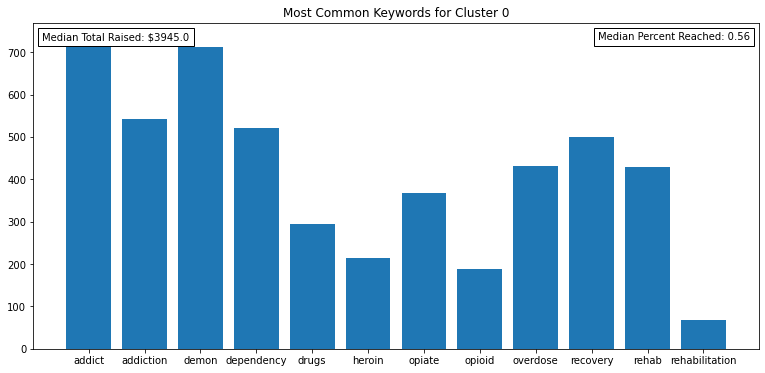

In [126]:
plot_kw_for_group(gmm_groups, 0)

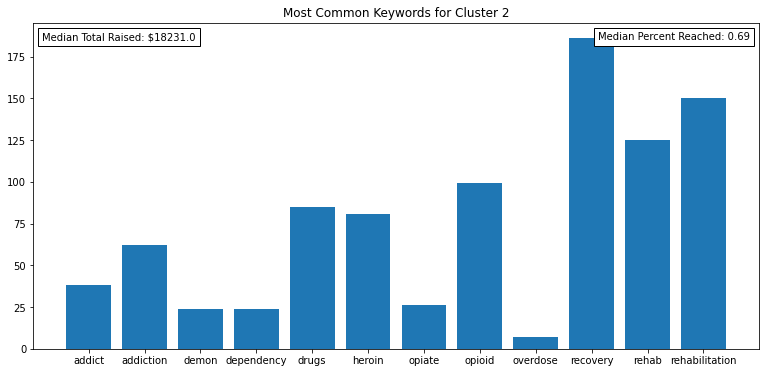

In [127]:
plot_kw_for_group(gmm_groups, 2)

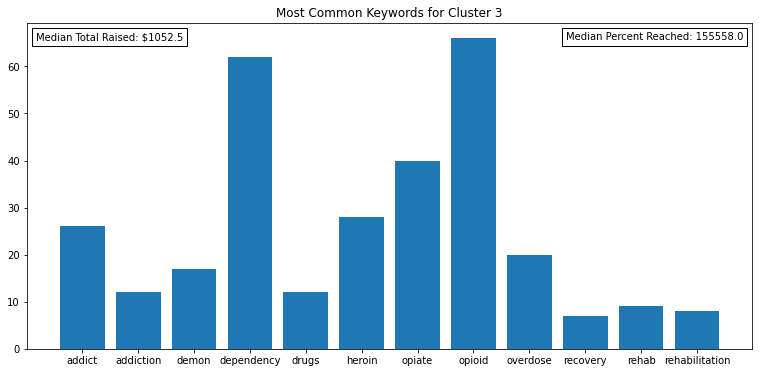

In [129]:
plot_kw_for_group(gmm_groups, 3)

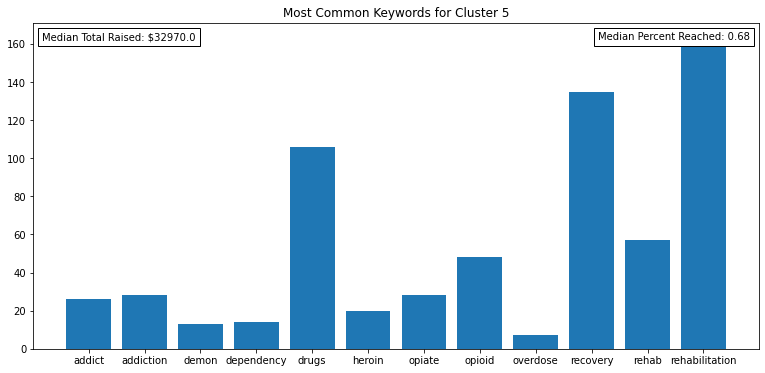

In [130]:
plot_kw_for_group(gmm_groups, 5)

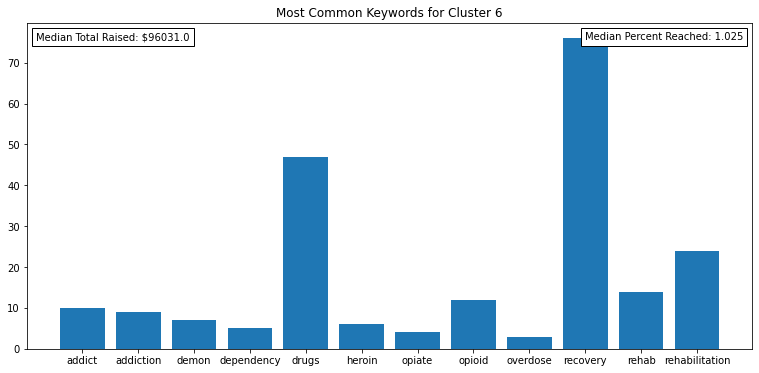

In [131]:
plot_kw_for_group(gmm_groups, 6)

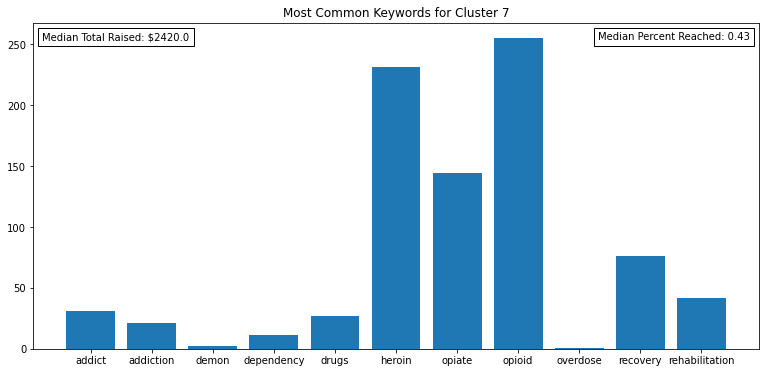

In [132]:
plot_kw_for_group(gmm_groups, 7)